In [ ]:
import datetime
import os

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from torch_geometric.utils.convert import from_networkx

device = torch.device('cuda')

from torch.utils.tensorboard import SummaryWriter

### Load data

In [ ]:
data = np.load('dataset_grafi_N300_compressed.npz')
dataset_grafi_np = data['arr_0']
dataset_grafi_np.shape

Num_grafi_per_tipo = 100

### Create Data object

In [3]:
dataset_pyg = []

i = 0
for g in tqdm(dataset_grafi_np,total = len(dataset_grafi_np)):
    nx_graph = nx.from_numpy_matrix(g)
    
    # aggiungo i metadati x e y per l'oggetto Data di PYG
    nodi = list(nx_graph.nodes)
    for n in nodi:
        nx_graph.nodes[n]["x"] = [1.0]
       
    pyg_graph = from_networkx(nx_graph)
    type_graph = 0 if i < Num_grafi_per_tipo else 1
    pyg_graph.y = torch.tensor([type_graph],dtype = torch.long)
    
    pyg_graph = pyg_graph.to(device)
    dataset_pyg.append(pyg_graph)
    i+=1


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.90it/s]


In [4]:
dataset_pyg[88].x.shape

torch.Size([300, 1])

In [5]:
#torch.manual_seed(12345)
import random

#dataset_pyg = dataset_pyg.shuffle()
random.shuffle(dataset_pyg)
len_data = len(dataset_pyg)
tt_split = int(len_data*0.7)
train_dataset = dataset_pyg[:tt_split]
test_dataset = dataset_pyg[tt_split:]

bs = 200
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 140
DataBatch(x=[42000, 1], edge_index=[2, 3891404], weight=[3891404], y=[140], batch=[42000], ptr=[141])



# Model Pytorch Geometric

In [26]:
node_features = 1
num_classes = 2

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
model.to(device)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def train(epoch):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss

def test(epoch):
    model.eval()
    for data in test_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
    return loss

def accuracy(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [57]:
nowstr = datetime.datetime.now().strftime("%d%b_%H-%M-%S")
expstr = ""
LOG_DIR = f"runs/{expstr}/{nowstr}"
print(LOG_DIR)
writer = SummaryWriter(LOG_DIR)

for epoch in range(1, 300):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_acc = accuracy(train_loader)
    test_acc = accuracy(test_loader)
    #writer.add_scalar("Loss/train", loss, epoch)
    #writer.add_scalar("Train accuracy", train_acc, epoch)
    #writer.add_scalar("Test accuracy", test_acc, epoch)
    writer.add_scalars(f'Loss', {'Train': train_loss, 'Test': test_loss}, epoch)
    writer.add_scalars(f'Accuracy', {'Train': train_acc, 'Test': test_acc}, epoch)
    #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
writer.flush()

runs/26Apr_22-48-51


### Take the embedding layer

In [9]:
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  conv2
Children Counter:  2  Layer Name:  conv3
Children Counter:  3  Layer Name:  lin


In [10]:
model._modules

OrderedDict([('conv1', GCNConv(1, 64)),
             ('conv2', GCNConv(64, 64)),
             ('conv3', GCNConv(64, 64)),
             ('lin', Linear(in_features=64, out_features=2, bias=True))])

In [11]:
import copy
model2 = copy.deepcopy(model)

if "embedding_model" in locals(): 
    del(embedding_model)

class embedding_model(torch.nn.Module):
    def __init__(self, old_model):
        super().__init__()
        #old_layers = list(old_model._modules.keys())
        #old_model._modules.pop(old_layers[-1])
        #self.net = torch.nn.Sequential(old_model)
        
        self.conv1 = old_model._modules['conv1']
        self.conv2 = old_model._modules['conv2']
        self.conv3 = old_model._modules['conv3']
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)##

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
     
        return x

In [12]:
embedding = embedding_model(model2)
embedding = embedding.to(device)

In [13]:
all_data_loader = DataLoader(dataset_pyg, batch_size=len_data, shuffle=False)

In [14]:
batch = next(iter(all_data_loader))
batch.x.shape

torch.Size([60000, 1])

In [15]:
res = embedding(batch.x, batch.edge_index, batch.batch)  

In [16]:
res.shape, len_data, len(dataset_pyg)

(torch.Size([200, 64]), 200, 200)

In [17]:
embeddings = res.cpu().detach().numpy()

In [18]:
embeddings.shape

(200, 64)

## T-sne

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embeddings)

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


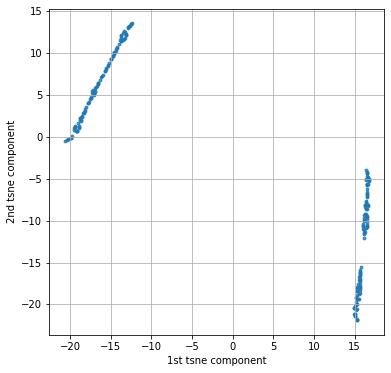

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.8, s=8)#, c=y)
plt.xlabel('1st tsne component')
plt.ylabel('2nd tsne component')
plt.grid()
plt.show()

### Distanze tra tutte le coppie

In [85]:
import itertools

NN = embeddings.shape[0]
coppie_num = list(itertools.combinations(range(NN), 2))
len(coppie_num) == (NN * (NN-1))/2
print(len(coppie_num))

19900


In [81]:
coppie = np.array([embeddings[c,:] for c in coppie_num])

In [86]:
coppie.shape

(19900, 2, 64)

In [84]:
# cosine distance
from numpy import dot
from numpy.linalg import norm

def cosdist(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [91]:
distances = [cosdist(a,b) for a,b in coppie]

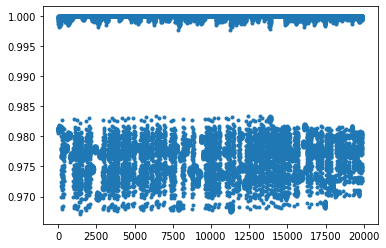

In [96]:
plt.plot(distances, '.')

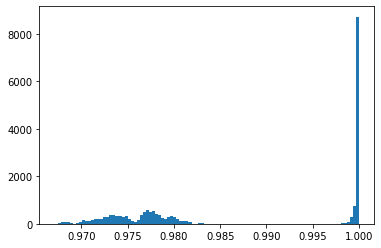

In [100]:
plt.hist(distances, bins=100);